In [157]:
import pandas as pd
import itertools
import ast
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=6, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [158]:
markup = pd.read_csv('../data/working_dir/gpt_markup_preprocessed.csv')
markup['gpt_markup_preprocessed'] = markup['gpt_markup_preprocessed'].fillna("{'-'}")
markup

,aspect,review,answers,gpt_markup,gpt_markup_preprocessed
0,описание личности персонажей,"По-настоящему живой фильм, держит все свои 118...",{'затронуты как личностный аспект человека и е...,NaN,{'-'}
1,описание игры актёров,Мстители стал первым экспериментом по сбор...,"{'Собственно сам сбор персонажей, и то какие м...","* Описание игры актёров, мнение об актёре или ...",{'-'}
2,описание декораций и графики,"Два взгляда столкнулись на море, Чтоб станц...",{'-'},NaN,{'-'}
3,описание игры актёров,"Жена главного героя, собственно Джона Уика, уш...","{'Микаэл Нюквист , недавно ворвавшийся в Голл...",В каждом актёре угадывается свой неповторимый ...,{'В каждом актёре угадывается свой неповторимы...
4,описание игры актёров,'Мумия' - фантастическая комедийная история о ...,"{'Есть еще нимало незаурядных личностей, котор...","* В роли Эвелин выступила актриса Рейчел Вайс,...",{'В роли её неугомонного брата выступил Джонн ...
...,...,...,...,...,...
94,характеристика внешности персонажей,Как много в кинематографе переоцененных фильмо...,{'-'},NaN,{'-'}
95,описание эмоций от просмотра фильма,Как много в кинематографе переоцененных фильмо...,"{'Лично я не растрогалась, глядя на людей. Рас...","В рецензии описывается трогательная история, н...","{'В рецензии описывается трогательная история,..."
96,описание декораций и графики,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии нет описания декораций и графики.\n...,{'-'}
97,философские рассуждения,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии встречаются следующие философские р...,{'«И поэтому-то к ним и обращаемся. Ну и разре...


In [159]:
def get_metric_concat_sets(row: pd.Series, metric):
    params = {}
    if metric.name == 'chrf':
        params['word_order'] = 0
    elif metric.name == 'bert_score':
        params['lang'] = 'ru'

    val = metric.compute(predictions=[' '.join(row['gpt_markup_preprocessed'])], references=[' '.join(row['answers'])], **params)
    return val


In [160]:
for cur_metr in ['bertscore', 'chrf', 'rouge', 'bleu']:
    print(cur_metr)
    metric = evaluate.load(cur_metr)
    metr_values = markup.progress_apply(get_metric_concat_sets, axis=1, args=(metric,))
    markup[f'concat_full_{cur_metr}'] = metr_values

bertscore


  0%|          | 0/99 [00:00<?, ?it/s]

chrf


  0%|          | 0/99 [00:00<?, ?it/s]

rouge


  0%|          | 0/99 [00:00<?, ?it/s]

bleu


  0%|          | 0/99 [00:00<?, ?it/s]

In [161]:
markup

,aspect,review,answers,gpt_markup,gpt_markup_preprocessed,concat_full_bertscore,concat_full_chrf,concat_full_rouge,concat_full_bleu
0,описание личности персонажей,"По-настоящему живой фильм, держит все свои 118...",{'затронуты как личностный аспект человека и е...,NaN,{'-'},"{'precision': [0.742644190788269], 'recall': [...","{'score': 2.5502988275012544, 'char_order': 6,...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.0, 'precisions': [0.8, 0.5, 0.0, 0...."
1,описание игры актёров,Мстители стал первым экспериментом по сбор...,"{'Собственно сам сбор персонажей, и то какие м...","* Описание игры актёров, мнение об актёре или ...",{'-'},"{'precision': [0.6771140098571777], 'recall': ...","{'score': 0.6792878357130377, 'char_order': 6,...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.0, 'precisions': [0.8, 0.5, 0.0, 0...."
2,описание декораций и графики,"Два взгляда столкнулись на море, Чтоб станц...",{'-'},NaN,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1...."
3,описание игры актёров,"Жена главного героя, собственно Джона Уика, уш...","{'Микаэл Нюквист , недавно ворвавшийся в Голл...",В каждом актёре угадывается свой неповторимый ...,{'В каждом актёре угадывается свой неповторимы...,"{'precision': [0.8878691792488098], 'recall': ...","{'score': 79.77598603851864, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.805580085091126, 'precisions': [0.8..."
4,описание игры актёров,'Мумия' - фантастическая комедийная история о ...,"{'Есть еще нимало незаурядных личностей, котор...","* В роли Эвелин выступила актриса Рейчел Вайс,...",{'В роли её неугомонного брата выступил Джонн ...,"{'precision': [0.7122259140014648], 'recall': ...","{'score': 23.73968001308012, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.09470423511543487, 'precisions': [0..."
...,...,...,...,...,...,...,...,...,...
94,характеристика внешности персонажей,Как много в кинематографе переоцененных фильмо...,{'-'},NaN,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1...."
95,описание эмоций от просмотра фильма,Как много в кинематографе переоцененных фильмо...,"{'Лично я не растрогалась, глядя на людей. Рас...","В рецензии описывается трогательная история, н...","{'В рецензии описывается трогательная история,...","{'precision': [0.818477213382721], 'recall': [...","{'score': 26.29160986734085, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.24683979874743822, 'precisions': [0..."
96,описание декораций и графики,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии нет описания декораций и графики.\n...,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1...."
97,философские рассуждения,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии встречаются следующие философские р...,{'«И поэтому-то к ним и обращаемся. Ну и разре...,"{'precision': [0.3184012472629547], 'recall': ...","{'score': 1.4818562510702553, 'char_order': 6,...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.0, 'precisions': [0.011013215859030..."


In [162]:
markup.to_csv('metrics_for_gpt_markup.csv', index=False)

In [163]:
def parse_concat_metrics(row: pd.Series, metric_name: str, sub_metric_name: str):
    if metric_name == 'bert_score':
        metric_name = 'bertscore'
    full_metric = row[f'concat_full_{metric_name}']
    return full_metric[sub_metric_name][0] if isinstance(full_metric[sub_metric_name], list) else full_metric[sub_metric_name]


In [164]:
sub_metrics_mapping = {
    'bert_score': {'precision', 'recall', 'f1'},
    'chrf': {'score'},
    'rouge': {'rouge1', 'rouge2', 'rougeL', 'rougeLsum'},
    'bleu': {'bleu', 'brevity_penalty'}
}

for metric_name in ['bert_score', 'chrf', 'rouge', 'bleu']:
    print(metric_name)
    for sub_metric_name in sub_metrics_mapping[metric_name]:
        metr_values = markup.progress_apply(parse_concat_metrics, axis=1, args=(metric_name, sub_metric_name))
        new_column_name = f'concat_{sub_metric_name}_{metric_name}' if metric_name in sub_metric_name or sub_metric_name in metric_name else f'concat_{sub_metric_name}'
        markup[f'concat_{sub_metric_name}_{metric_name}'] = metr_values

bert_score


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

chrf


  0%|          | 0/99 [00:00<?, ?it/s]

rouge


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

bleu


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [165]:
markup

,aspect,review,answers,gpt_markup,gpt_markup_preprocessed,concat_full_bertscore,concat_full_chrf,concat_full_rouge,concat_full_bleu,concat_precision_bert_score,concat_f1_bert_score,concat_recall_bert_score,concat_score_chrf,concat_rouge1_rouge,concat_rouge2_rouge,concat_rougeL_rouge,concat_rougeLsum_rouge,concat_bleu_bleu,concat_brevity_penalty_bleu
0,описание личности персонажей,"По-настоящему живой фильм, держит все свои 118...",{'затронуты как личностный аспект человека и е...,NaN,{'-'},"{'precision': [0.742644190788269], 'recall': [...","{'score': 2.5502988275012544, 'char_order': 6,...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.0, 'precisions': [0.8, 0.5, 0.0, 0....",0.742644,0.619166,0.530895,2.550299,0.0,0.0,0.0,0.0,0.000000,2.491601e-05
1,описание игры актёров,Мстители стал первым экспериментом по сбор...,"{'Собственно сам сбор персонажей, и то какие м...","* Описание игры актёров, мнение об актёре или ...",{'-'},"{'precision': [0.6771140098571777], 'recall': ...","{'score': 0.6792878357130377, 'char_order': 6,...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.0, 'precisions': [0.8, 0.5, 0.0, 0....",0.677114,0.497678,0.393420,0.679288,0.0,0.0,0.0,0.0,0.000000,2.115131e-19
2,описание декораций и графики,"Два взгляда столкнулись на море, Чтоб станц...",{'-'},NaN,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1....",1.000000,1.000000,1.000000,100.000000,0.0,0.0,0.0,0.0,1.000000,1.000000e+00
3,описание игры актёров,"Жена главного героя, собственно Джона Уика, уш...","{'Микаэл Нюквист , недавно ворвавшийся в Голл...",В каждом актёре угадывается свой неповторимый ...,{'В каждом актёре угадывается свой неповторимы...,"{'precision': [0.8878691792488098], 'recall': ...","{'score': 79.77598603851864, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.805580085091126, 'precisions': [0.8...",0.887869,0.886924,0.885981,79.775986,0.0,0.0,0.0,0.0,0.805580,1.000000e+00
4,описание игры актёров,'Мумия' - фантастическая комедийная история о ...,"{'Есть еще нимало незаурядных личностей, котор...","* В роли Эвелин выступила актриса Рейчел Вайс,...",{'В роли её неугомонного брата выступил Джонн ...,"{'precision': [0.7122259140014648], 'recall': ...","{'score': 23.73968001308012, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.09470423511543487, 'precisions': [0...",0.712226,0.726034,0.740388,23.739680,0.0,0.0,0.0,0.0,0.094704,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,характеристика внешности персонажей,Как много в кинематографе переоцененных фильмо...,{'-'},NaN,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1....",1.000000,1.000000,1.000000,100.000000,0.0,0.0,0.0,0.0,1.000000,1.000000e+00
95,описание эмоций от просмотра фильма,Как много в кинематографе переоцененных фильмо...,"{'Лично я не растрогалась, глядя на людей. Рас...","В рецензии описывается трогательная история, н...","{'В рецензии описывается трогательная история,...","{'precision': [0.818477213382721], 'recall': [...","{'score': 26.29160986734085, 'char_order': 6, ...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 0.24683979874743822, 'precisions': [0...",0.818477,0.824922,0.831468,26.291610,0.0,0.0,0.0,0.0,0.246840,1.000000e+00
96,описание декораций и графики,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии нет описания декораций и графики.\n...,{'-'},"{'precision': [0.9999998807907104], 'recall': ...","{'score': 100.0, 'char_order': 6, 'word_order'...","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, ...","{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1....",1.000000,1.

In [166]:
markup.isna().any()

aspect                         False
review                         False
answers                        False
gpt_markup                      True
gpt_markup_preprocessed        False
concat_full_bertscore          False
concat_full_chrf               False
concat_full_rouge              False
concat_full_bleu               False
concat_precision_bert_score    False
concat_f1_bert_score           False
concat_recall_bert_score       False
concat_score_chrf              False
concat_rouge1_rouge            False
concat_rouge2_rouge            False
concat_rougeL_rouge            False
concat_rougeLsum_rouge         False
concat_bleu_bleu               False
concat_brevity_penalty_bleu    False
dtype: bool

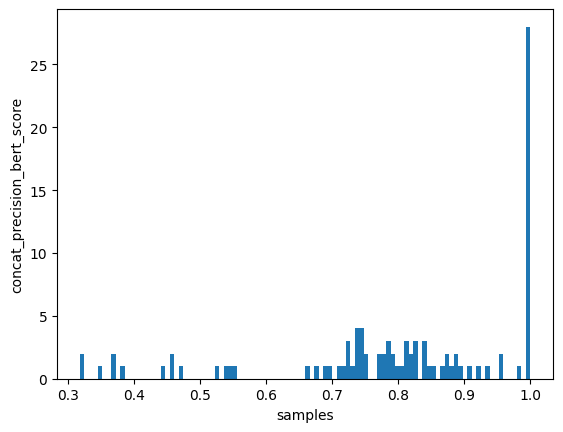

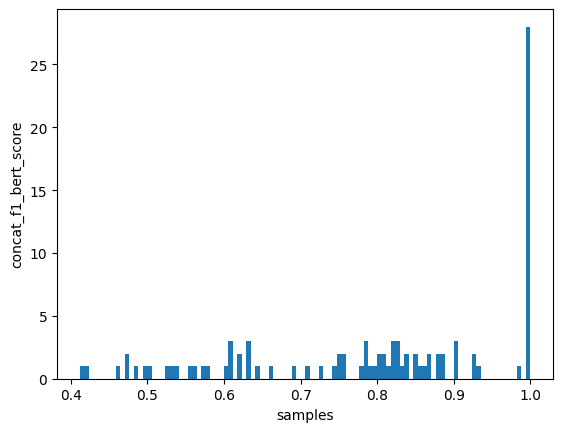

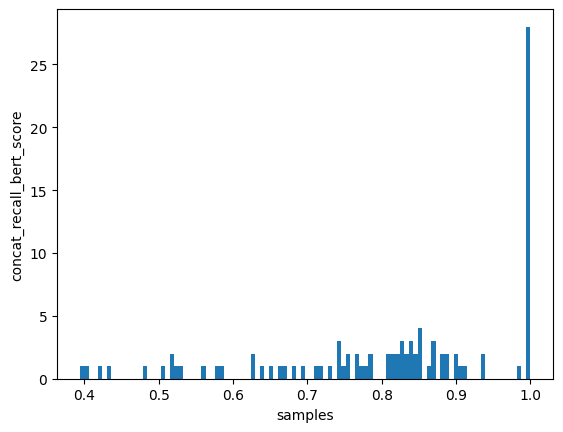

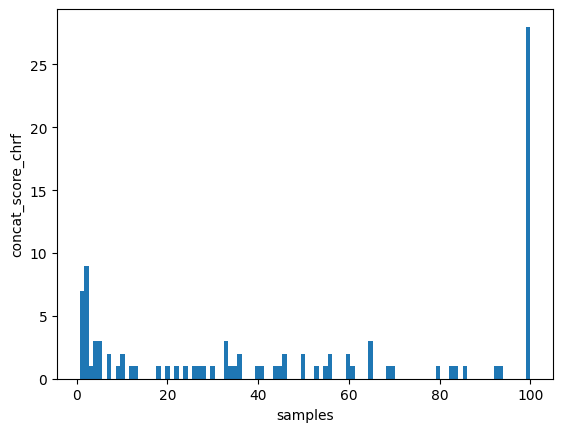

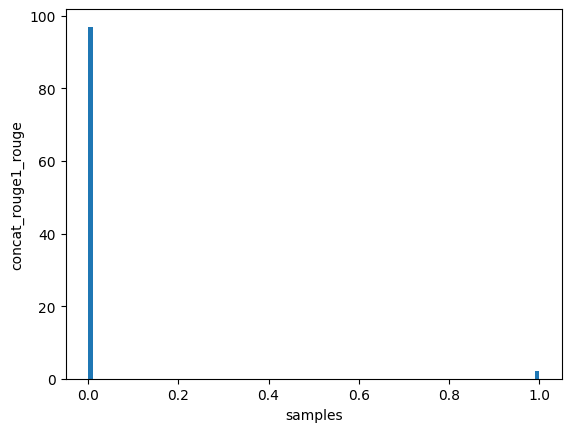

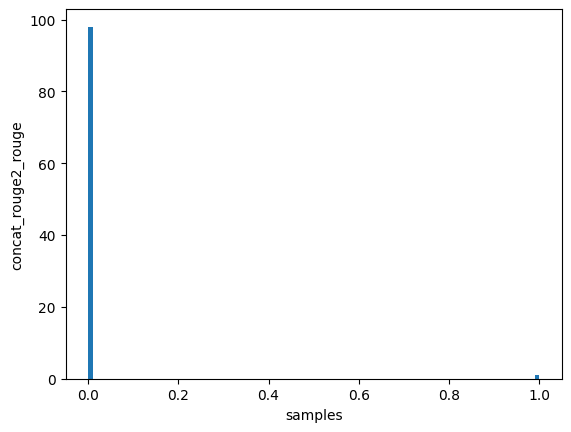

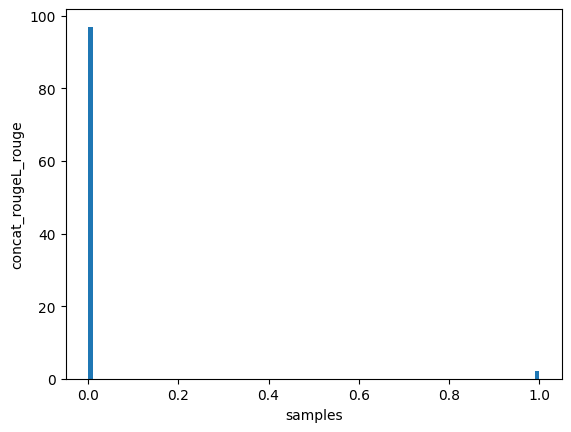

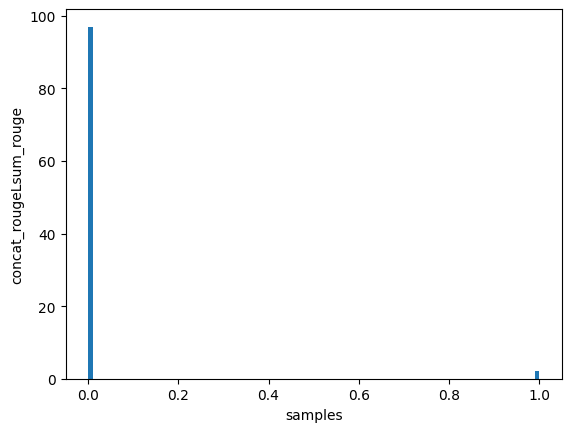

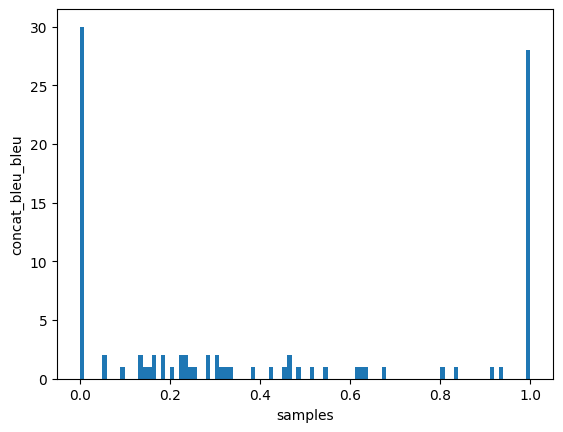

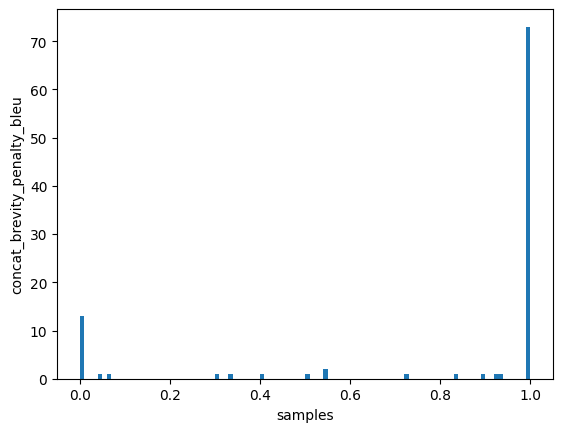

In [168]:
for col in markup.columns[-10:]:
    plt.hist(markup[col], bins=100)
    plt.xlabel('samples')
    plt.ylabel(col)
    plt.show()

---

In [25]:
ast.literal_eval('{1, 2, 3, 4}')

{1, 2, 3, 4}

In [27]:
def process_row_for_metric(row: pd.Series):
    return list(itertools.product(ast.literal_eval(row['answers']), ast.literal_eval(row['gpt_markup_preprocessed'])))

markup['product'] = markup.apply(process_row_for_metric, axis=1)
markup

,aspect,review,answers,gpt_markup,gpt_markup_preprocessed,product
0,описание личности персонажей,"По-настоящему живой фильм, держит все свои 118...",{'затронуты как личностный аспект человека и е...,NaN,{'-'},[(затронуты как личностный аспект человека и е...
1,описание игры актёров,Мстители стал первым экспериментом по сбор...,"{'Собственно сам сбор персонажей, и то какие м...","* Описание игры актёров, мнение об актёре или ...",{'-'},"[(Собственно сам сбор персонажей, и то какие м..."
2,описание декораций и графики,"Два взгляда столкнулись на море, Чтоб станц...",{'-'},NaN,{'-'},"[(-, -)]"
3,описание игры актёров,"Жена главного героя, собственно Джона Уика, уш...","{'Микаэл Нюквист , недавно ворвавшийся в Голл...",В каждом актёре угадывается свой неповторимый ...,{'В каждом актёре угадывается свой неповторимы...,"[(Микаэл Нюквист , недавно ворвавшийся в Голл..."
4,описание игры актёров,'Мумия' - фантастическая комедийная история о ...,"{'Есть еще нимало незаурядных личностей, котор...","* В роли Эвелин выступила актриса Рейчел Вайс,...",{'В роли её неугомонного брата выступил Джонн ...,"[(Несомненно, это одна из лучших ролей Брендан..."
...,...,...,...,...,...,...
94,характеристика внешности персонажей,Как много в кинематографе переоцененных фильмо...,{'-'},NaN,{'-'},"[(-, -)]"
95,описание эмоций от просмотра фильма,Как много в кинематографе переоцененных фильмо...,"{'Лично я не растрогалась, глядя на людей. Рас...","В рецензии описывается трогательная история, н...","{'В рецензии описывается трогательная история,...","[(Лично я не растрогалась, глядя на людей. Рас..."
96,описание декораций и графики,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии нет описания декораций и графики.\n...,{'-'},"[(-, -)]"
97,философские рассуждения,Как много в кинематографе переоцененных фильмо...,{'-'},В рецензии встречаются следующие философские р...,{'«И поэтому-то к ним и обращаемся. Ну и разре...,"[(-, «В этот век равнодушия человека к человек..."


In [51]:
rouge = evaluate.load('rouge')
metrics = []

for i in trange(len(markup)):
    for j in range(len(markup['product'].iloc[i])):
        # print(markup['product'].iloc[i])
        # print(markup['product'].iloc[i][j])
        # print(markup['product'].iloc[i][j][0])
        # print(markup['product'].iloc[i][j][1])
        val = rouge.compute(predictions=[markup['product'].iloc[i][j][1]], references=[markup['product'].iloc[i][j][0]])
        metrics.append(val)

  0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
chrf = evaluate.load('chrf')
metrics = []

for i in trange(len(markup)):
    local_metrics = []
    for j in range(len(markup['product'].iloc[i])):
        val = chrf.compute(predictions=[markup['product'].iloc[i][j][1]], references=[markup['product'].iloc[i][j][0]])
        local_metrics.append(val['score'])
    metrics.append(pd.max(local_metrics))

  0%|          | 0/99 [00:00<?, ?it/s]

In [61]:
metrics

[{'score': 0.0, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 0.0, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 0.0, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 100.0, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 13.135042566356953, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 43.07367933135187, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 48.283433356002156, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 8.037976343510241, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 5.719303369308824, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 5.578860818622432, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 8.292222576031847, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 7.67945781533369, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 11.615239115641064, 'char_order': 6, 'word_order': 0, 'beta': 2},
 {'score': 7.971569066037085, 'char_order': 6, 'word_order': 0, 

In [62]:
list(map(lambda el: el['score'], metrics))

[0.0,
 0.0,
 0.0,
 100.0,
 13.135042566356953,
 43.07367933135187,
 48.283433356002156,
 8.037976343510241,
 5.719303369308824,
 5.578860818622432,
 8.292222576031847,
 7.67945781533369,
 11.615239115641064,
 7.971569066037085,
 11.135360548355143,
 24.897258673466332,
 5.247207166327942,
 3.915377086698394,
 29.89324942711164,
 27.41284299099995,
 100.0,
 16.59691588533898,
 17.238578165086736,
 10.648508857178347,
 9.663445373824674,
 8.080009998863973,
 11.756902553498685,
 12.641159675756676,
 24.09693649059415,
 12.994420453458188,
 12.923797541770227,
 19.16641140273734,
 14.499769508422592,
 15.123925384518078,
 39.481219647496204,
 11.208090750873648,
 9.835024863508346,
 19.102541003862918,
 20.298654861605193,
 19.505558074573194,
 14.593469971146131,
 16.609120919078542,
 18.228327027967964,
 13.583661486020986,
 18.48910630578744,
 9.970880980141999,
 11.183874844445242,
 15.05202803317365,
 13.089483520137456,
 17.115064816941484,
 13.751567594442943,
 10.885558671076822,


(array([232., 302.,  29.,  18.,   9.,   7.,   4.,   5.,   6.,  53.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

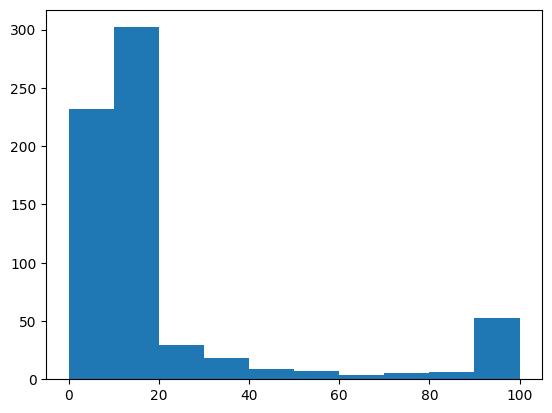

In [64]:
plt.hist(list(map(lambda el: el['score'], metrics)), )